__<h2>Importent Setup and library:</h2>__

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pathlib
data_dir = "/content/drive/MyDrive/MLProjects/dataset/chest_xray"
data_dir_train = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/Train"
data_dir_validation = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/Test"

Data cleaning

In [43]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/"
image_extensions = [".png", ".svg", ".gif", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [44]:
img_height,img_width=180, 180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5242 files belonging to 2 classes.


In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [46]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


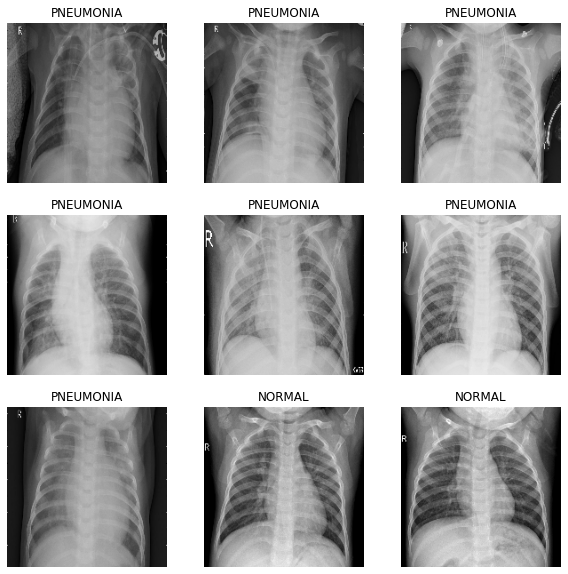

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


164/164 [==============================] - 818s 5s/step - loss: 0.1750 - accuracy: 0.9311 - val_loss: 1.3910 - val_accuracy: 0.6923
Epoch 2/3
164/164 [==============================] - 33s 193ms/step - loss: 0.0956 - accuracy: 0.9647 - val_loss: 0.9647 - val_accuracy: 0.7821
Epoch 3/3
164/164 [==============================] - 33s 195ms/step - loss: 0.0658 - accuracy: 0.9756 - val_loss: 0.7435 - val_accuracy: 0.8125


In [3]:
activation=2
model = model((180,180,3),activation)
keras.utils.plot_model(model, show_shapes=True)

NameError: ignored

In [56]:
tf.keras.models.save_model(model,'xray_model.hdf5')

In [1]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 12.7 MB/s 
     |████████████████████████████████| 182 kB 51.6 MB/s 
     |████████████████████████████████| 4.7 MB 55.4 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 164 kB 54.7 MB/s 
     |████████████████████████████████| 237 kB 74.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 8.9 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=2183e5e3834c20c06713934eeef4fbc22ebdccfc4f1276afb1d8a14021b07463
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [2]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Writing app.py
